In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) #makes the display bars longer and spread out 100% across the screen width

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

!pwd
!whoami
!date

/ihme/homes/ndbs/vivarium_research_ciff_sam/nathaniel/model_validation/model2
ndbs
Tue Jul 27 15:21:36 PDT 2021


# 2.1: WASTING (RISK validation)

## wasting risk vv

In [4]:
%cd /ihme/costeffectiveness/results/vivarium_ciff_sam/v2.3_wasting_birth_prevalence/ciff_sam/2021_07_26_17_14_31/count_data
%ls

/ihme/costeffectiveness/results/vivarium_ciff_sam/v2.3_wasting_birth_prevalence/ciff_sam/2021_07_26_17_14_31/count_data
deaths.csv                     population.csv                 ylds.csv
deaths.hdf                     population.hdf                 ylds.hdf
disease_state_person_time.csv  wasting_state_person_time.csv  ylls.csv
disease_state_person_time.hdf  wasting_state_person_time.hdf  ylls.hdf
disease_transition_count.csv   wasting_transition_count.csv
disease_transition_count.hdf   wasting_transition_count.hdf


In [13]:
# master_dir = '/home/j/Project/simulation_science/ciff_malnutrition/'
master_dir = '/share/scratch/users/ndbs/vivarium_results/ciff_malnutrition/'
sim_result_dir = '/ihme/costeffectiveness/results/vivarium_ciff_sam/v2.3_wasting_birth_prevalence/ciff_sam/2021_07_26_17_14_31/count_data/'
output_dir = master_dir + f'verification_and_validation/v2.3_wasting_birth_prevalence/'


## LOAD SIM DATA

In [14]:
def load_sim_count_data(sim_result_dir: str):
    columns = ['age', 'sex', 'year', 'input_draw', 'scenario', 'measure']
    df = {}
    fnames = ['deaths', 'disease_transition_count', 'wasting_transition_count',
              'disease_state_person_time', 'wasting_state_person_time']
    for fname in fnames:
        df[fname] = pd.read_csv(sim_result_dir + fname + '.csv', index_col=0)
        # get aggregated results if stratifications exist
        if 'cause' in df[fname].columns:
            df[fname] = df[fname].groupby(columns + ['cause']).value.sum().reset_index()
        else:
            df[fname] = df[fname].groupby(columns).value.sum().reset_index()
    return df

df = load_sim_count_data(sim_result_dir)

In [15]:
pd.read_csv(sim_result_dir + 'wasting_transition_count.csv', index_col=0).query('measure == "susceptible_to_child_wasting_to_mild_child_wasting_event_count"')

,sex,year,measure,input_draw,scenario,value,age
432,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,16.0,early_neonatal
433,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,76.0,late_neonatal
434,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,1262.0,1-5_months
435,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,3029.0,6-11_months
...,...,...,...,...,...,...,...
5036,male,2026,susceptible_to_child_wasting_to_mild_child_was...,946,baseline,479.0,1-5_months
5037,male,2026,susceptible_to_child_wasting_to_mild_child_was...,946,baseline,674.0,6-11_months
5038,male,2026,susceptible_to_child_wasting_to_mild_child_was...,946,baseline,1270.0,12_to_23_months
5039,male,2026,susceptible_to_child_wasting_to_mild_child_was...,946,baseline,6814.0,2_to_4


In [16]:
results = pd.read_csv(sim_result_dir + 'wasting_transition_count.csv', index_col=0)
incidence_mild_count = results.query('measure == "susceptible_to_child_wasting_to_mild_child_wasting_event_count"')
incidence_mild_count.head()

,sex,year,measure,input_draw,scenario,value,age
432,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,16.0,early_neonatal
433,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,76.0,late_neonatal
434,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,1262.0,1-5_months
435,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,3029.0,6-11_months
436,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,7434.0,12_to_23_months


In [17]:
incidence_mild_count \
.groupby(['year','age']) \
.sum().drop(columns='input_draw').reset_index().set_index(['age']) \
.pivot(columns = 'year')

value                                        
year                 2022      2023      2024      2025      2026
age                                                              
1-5_months        32311.0   12820.0   12874.0   12660.0   12518.0
12_to_23_months  193350.0  113987.0   30941.0   30443.0   30784.0
2_to_4           521063.0  524364.0  455811.0  307733.0  159454.0
6-11_months       77725.0   15324.0   15525.0   15389.0   15554.0
early_neonatal      530.0     514.0     498.0     512.0     523.0
late_neonatal      1829.0    1539.0    1430.0    1493.0    1431.0

### WASTING STATE TRANSITION COUNTS

In [18]:
incidence_mild_count = (df['wasting_transition_count'].query('measure == "susceptible_to_child_wasting_to_mild_child_wasting_event_count"'))
incidence_mild_count['risk'] = 'mild_wasting'
incidence_mild_count['measure'] = 'incidence'

incidence_mam_count = (df['wasting_transition_count'].query('measure == "mild_child_wasting_to_moderate_acute_malnutrition_event_count"'))
incidence_mam_count['risk'] = 'mam'
incidence_mam_count['measure'] = 'incidence'

incidence_sam_count = (df['wasting_transition_count'].query('measure == "moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count"'))
incidence_sam_count['risk'] = 'sam'
incidence_sam_count['measure'] = 'incidence'

remission_sam_count = (df['wasting_transition_count'].query('measure == "severe_acute_malnutrition_to_moderate_acute_malnutrition_event_count"'))
remission_sam_count['risk'] = 'sam'
remission_sam_count['measure'] = 'remission'

remission_mam_count = (df['wasting_transition_count'].query('measure == "moderate_acute_malnutrition_to_mild_child_wasting_event_count"'))
remission_mam_count['risk'] = 'mam'
remission_mam_count['measure'] = 'remission'

remission_mild_count = (df['wasting_transition_count'].query('measure == "mild_child_wasting_to_susceptible_to_child_wasting_event_count"'))
remission_mild_count['risk'] = 'mild_wasting'
remission_mild_count['measure'] = 'remission'

### WASTING STATE PERSON TIME

In [19]:
person_time_sus_wasting = df['wasting_state_person_time'].query('cause == "susceptible_to_child_wasting"')
person_time_mild_wasting = df['wasting_state_person_time'].query('cause == "mild_child_wasting"')
person_time_mam = df['wasting_state_person_time'].query('cause == "moderate_acute_malnutrition"')
person_time_sam = df['wasting_state_person_time'].query('cause == "severe_acute_malnutrition"')

#### TOTAL PERSON TIME

In [20]:
df['disease_person_time'] = df['disease_state_person_time'].loc[
    df['disease_state_person_time'].cause.isin(['diarrheal_diseases','susceptible_to_diarrheal_diseases'])
].groupby(['age','sex','year','input_draw','scenario','measure']).sum().reset_index()

df['disease_person_time']['cause'] = 'all_causes'

In [21]:
df['disease_state_person_time'].loc[
    df['disease_state_person_time'].cause.isin(['diarrheal_diseases','susceptible_to_diarrheal_diseases'])].value.sum()

22168476.633812457

In [22]:
df['risk_person_time'] = df['wasting_state_person_time'].groupby(['age','sex','year','input_draw','scenario','measure']).sum().reset_index()
df['risk_person_time']['cause'] = 'all_causes'

In [23]:
# i think the disease person time v risk person time should be equal
df['disease_person_time'].value.sum()

22168476.633812457

In [24]:
df['risk_person_time'].value.sum()

35205674.31759069

## CALCULATE SIM MEASURES

In [25]:
def get_measure(data: pd.DataFrame, denom: pd.DataFrame, entity: str):
    """
    rate per PY among source population
    note the numerator is 'data' and denominator is df['person_time']
    """
    
    result = ((data
               .set_index(['age', 'sex', 'year', 'input_draw', 'scenario', 'measure', entity])
               .div(denom.drop(columns=['measure', 'cause'])
                    .set_index(['age', 'sex', 'year', 'input_draw', 'scenario'])))
              .reset_index())
    
    result['age_group'] = np.where(result['age'] == 'early_neonatal', 1,
                              np.where(result['age'] == 'late_neonatal', 2,
                                       np.where(result['age'] == '1-5_months',3,
                                                np.where(result['age'] == '6-11_months',4,
                                                         np.where(result['age'] == '12_to_23_months',5,
                                                         6)))))
    
    result_summary = (result
                      .groupby(['age_group', 'sex', 'year', 'scenario', 'measure', entity])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
    
    return result_summary

In [26]:
df.keys()

dict_keys(['deaths', 'disease_transition_count', 'wasting_transition_count', 'disease_state_person_time', 'wasting_state_person_time', 'disease_person_time', 'risk_person_time'])

### PREVALENCE

In [27]:
# risk prevalence
prevalence_wasting_tmrel = get_measure(person_time_sus_wasting, df['risk_person_time'], 'cause')
prevalence_mild = get_measure(person_time_mild_wasting, df['risk_person_time'], 'cause')
prevalence_mam = get_measure(person_time_mam, df['risk_person_time'], 'cause')
prevalence_sam = get_measure(person_time_sam, df['risk_person_time'], 'cause')

### INCIDENCE

In [28]:
incidence_mild = get_measure(incidence_mild_count, denom = person_time_sus_wasting, entity = 'risk')
incidence_mam = get_measure(incidence_mam_count, denom = person_time_mild_wasting, entity = 'risk')
incidence_sam = get_measure(incidence_sam_count, denom = person_time_mam, entity = 'risk')

### REMISSION

In [29]:
remission_mild = get_measure(remission_mild_count, denom = person_time_mild_wasting, entity = 'risk')
remission_mam = get_measure(remission_mam_count, denom = person_time_mam, entity = 'risk')
remission_sam = get_measure(remission_sam_count, denom = person_time_sam, entity = 'risk')

# ARTIFACT

In [30]:
#filepath

%cd /ihme/costeffectiveness/artifacts/vivarium_ciff_sam/
%ls

/ihme/costeffectiveness/artifacts/vivarium_ciff_sam
backup-2.hdf  backup.hdf  ethiopia.hdf


In [31]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/ihme/costeffectiveness/artifacts/vivarium_ciff_sam/ethiopia.hdf', filter_terms=['year_start == 2019', f'age_end <= 5'])

In [32]:
#load population structure

art_pop = art.load('population.structure').reset_index()

In [33]:
art_pop

,location,sex,age_start,age_end,year_start,year_end,value
0,Ethiopia,Female,0.000000,0.019178,2019,2020,3.381118e+04
1,Ethiopia,Female,0.019178,0.076712,2019,2020,1.002102e+05
2,Ethiopia,Female,0.076712,1.000000,2019,2020,1.573806e+06
3,Ethiopia,Female,1.000000,5.000000,2019,2020,6.437387e+06
4,Ethiopia,Male,0.000000,0.019178,2019,2020,3.570018e+04
5,Ethiopia,Male,0.019178,0.076712,2019,2020,1.053044e+05
6,Ethiopia,Male,0.076712,1.000000,2019,2020,1.651227e+06
7,Ethiopia,Male,1.000000,5.000000,2019,2020,6.742224e+06


In [34]:
def load_wasting_prev(cat):
    data = art.load('risk_factor.child_wasting.exposure')
    
    data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()

    data['age'] = 0
    
    data['age'] = np.where(data['age_start'] == 0, 'early_neonatal', #1
                                            np.where(data['age_end'] == 0.5, '1-5_months', #3
                                                     np.where(data['age_start'] == 0.5, '6-11_months', #4
                                                              np.where(data['age_start'] == 1, '12_to_23_months',  #5
                                                                       np.where(data['age_start'] == 2, '2_to_4',       #6
                                                                       'late_neonatal'))))) #2
        
    data['age_group'] = np.where(data['age'] == 'early_neonatal', 1,
                                   np.where(data['age'] == 'late_neonatal', 2,
                                            np.where(data['age'] == '1-5_months', 3, 
                                                     np.where(data['age'] == '6-11_months', 4, 
                                                              np.where(data['age'] == '12_to_23_months', 5,
                                    6)))))


    data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
    #subset to cat
    risk_dict = {
        'cat1':'sam',
        'cat2':'mam',
        'cat3':'mild_wasting',
        'cat4':'tmrel_wasting'
    }
    data['risk'] = data.parameter.map(risk_dict)
    data = data.loc[data.parameter==cat].drop(columns=['parameter'])
    data['measure'] = 'prevalence'
    
    return data

In [35]:
sam_prev = load_wasting_prev('cat1')
mam_prev = load_wasting_prev('cat2')
mild_prev = load_wasting_prev('cat3')
sus_wasting_prev = load_wasting_prev('cat4')

In [36]:
sam_prev

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,age,age_group,risk,measure
0,female,0.000000,0.019178,2019,2020,0.024557,0.021287,0.028370,early_neonatal,1,sam,prevalence
4,female,0.019178,0.076712,2019,2020,0.024610,0.021256,0.028680,late_neonatal,2,sam,prevalence
8,female,0.076712,0.500000,2019,2020,0.024987,0.021183,0.028627,1-5_months,3,sam,prevalence
12,female,0.500000,1.000000,2019,2020,0.025921,0.022489,0.029991,6-11_months,4,sam,prevalence
...,...,...,...,...,...,...,...,...,...,...,...,...
32,male,0.076712,0.500000,2019,2020,0.040833,0.035179,0.046745,1-5_months,3,sam,prevalence
36,male,0.500000,1.000000,2019,2020,0.038799,0.033571,0.044388,6-11_months,4,sam,prevalence
40,male,1.000000,2.000000,2019,2020,0.028636,0.024285,0.032975,12_to_23_months,5,sam,prevalence
44,male,2.000000,5.000000,2019,2020,0.016175,0.013549,0.018823,2_to_4,6,sam,prevalence


In [37]:
sam_prev.year_start.unique()

array([2019])

In [38]:
data = art.load('risk_factor.child_wasting.exposure')
data

draw_0    draw_1  \
sex    age_start age_end  year_start year_end parameter                       
Female 0.0       0.019178 2019       2020     cat1       0.025542  0.022101   
                                              cat2       0.084023  0.079775   
                                              cat3       0.202135  0.203205   
                                              cat4       0.688300  0.694919   
...                                                           ...       ...   
Male   2.0       5.000000 2019       2020     cat1       0.018393  0.016716   
                                              cat2       0.078225  0.075297   
                                              cat3       0.212657  0.209826   
                                              cat4       0.690724  0.698160   

                                                           draw_2    draw_3  \
sex    age_start age_end  year_start year_end parameter                       
Female 0.0       0.019178 2019       2020     cat1       0.025495  0.026181   
                                              cat2       0.084199  0.083253   
                                              cat3       0.202844  0.199185   
                                              cat4       0.687463  0.691380   
...                                                           ...       ...   
Male   2.0       5.000000 2019       2020     cat1       0.015746  0.016250   
                                              cat2       0.073713  0.073600   
                                              cat3       0.210035  0.207364   
                                              cat4       0.700506  0.702787   

                                                           draw_4    draw_5  \
sex    age_start age_end  year_start year_end parameter                       
Female 0.0       0.019178 2019       2020     cat1       0.022688  0.028790   
                                              cat2       0.080105  0.086188   
                                              cat3       0.201203  0.197853   
                                              cat4       0.696005  0.687169   
...                                                           ...       ...   
Male   2.0       5.000000 2019       2020     cat1       0.013366  0.017258   
                                              cat2       0.070075  0.075379   
                                              cat3       0.212434  0.209071   
                                              cat4       0.704125  0.698292   

                                                           draw_6    draw_7  \
sex    age_start age_end  year_start year_end parameter                       
Female 0.0       0.019178 2019       2020     cat1       0.027967  0.021531   
                                              cat2       0.084574  0.077547   
                                              cat3       0.199880  0.197378   
                                              cat4       0.687580  0.703544   
...                                                           ...       ...   
Male   2.0       5.000000 2019       2020     cat1       0.015111  0.013541   
                                              cat2       0.074453  0.071795   
                                              cat3       0.214033  0.215055   
                                              cat4       0.696403  0.699609   

                                                           draw_8    draw_9  \
sex    age_start age_end  year_start year_end parameter                       
Female 0.0       0.019178 2019       2020     cat1       0.022314  0.025467   
                                              cat2       0.079266  0.083797   
                                              cat3       0.201108  0.202998   
                                              cat4       0.697311  0.687738   
...                                                           ...       ...   
Male   2.0       5.000000 

In [39]:
def load_all_wasting_prev():
    data = art.load('risk_factor.child_wasting.exposure')
    
    data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()

    data['age'] = 0
    
    data['age'] = np.where(data['age_start'] == 0, 'early_neonatal', #1
                                            np.where(data['age_end'] == 0.5, '1-5_months', #3
                                                     np.where(data['age_start'] == 0.5, '6-11_months', #4
                                                              np.where(data['age_start'] == 1, '12_to_23_months',  #5
                                                                       np.where(data['age_start'] == 2, '2_to_4',       #6
                                                                       'late_neonatal'))))) #2
        
    data['age_group'] = np.where(data['age'] == 'early_neonatal', 1,
                                   np.where(data['age'] == 'late_neonatal', 2,
                                            np.where(data['age'] == '1-5_months', 3, 
                                                     np.where(data['age'] == '6-11_months', 4, 
                                                              np.where(data['age'] == '12_to_23_months', 5,
                                    6)))))


    data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
    #subset to cat
    risk_dict = {
        'cat1':'sam',
        'cat2':'mam',
        'cat3':'mild_wasting',
        'cat4':'tmrel_wasting'
    }
    data['risk'] = data.parameter.map(risk_dict)
    data = data.drop(columns=['parameter'])
    data['measure'] = 'prevalence'
    
    return data

art_wasting_prev = load_all_wasting_prev()
art_wasting_prev

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,age,age_group,risk,measure
0,female,0.0,0.019178,2019,2020,0.024557,0.021287,0.028370,early_neonatal,1,sam,prevalence
1,female,0.0,0.019178,2019,2020,0.082311,0.078291,0.086317,early_neonatal,1,mam,prevalence
2,female,0.0,0.019178,2019,2020,0.201385,0.196609,0.206213,early_neonatal,1,mild_wasting,prevalence
3,female,0.0,0.019178,2019,2020,0.691747,0.683254,0.700573,early_neonatal,1,tmrel_wasting,prevalence
...,...,...,...,...,...,...,...,...,...,...,...,...
44,male,2.0,5.000000,2019,2020,0.016175,0.013549,0.018823,2_to_4,6,sam,prevalence
45,male,2.0,5.000000,2019,2020,0.074177,0.070301,0.078136,2_to_4,6,mam,prevalence
46,male,2.0,5.000000,2019,2020,0.210504,0.204676,0.216590,2_to_4,6,mild_wasting,prevalence
47,male,2.0,5.000000,2019,2020,0.699143,0.690327,0.707901,2_to_4,6,tmrel_wasting,prevalence


# PLOT

In [40]:
def summarize_df(data: pd.DataFrame, entity: str):
    result = data.reset_index()
    
    result['age_group'] = np.where(result['age'] == 'early_neonatal', 1,
                              np.where(result['age'] == 'late_neonatal', 2,
                                       np.where(result['age'] == '1-5_months',3,
                                                np.where(result['age'] == '6-11_months',4,
                                                         np.where(result['age'] == '12_to_23_months',5,
                                                         6)))))
    
    group_cols = ['age_group', 'sex', 'year', 'scenario', 'measure'] + [entity]
    
    result_summary = (result
                      .groupby(group_cols)
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
    return result_summary

In [41]:
incidence_mild_count.groupby(['year','age']).sum().drop(columns='input_draw').reset_index().set_index(['age']).pivot(columns = 'year')

value                                        
year                 2022      2023      2024      2025      2026
age                                                              
1-5_months        32311.0   12820.0   12874.0   12660.0   12518.0
12_to_23_months  193350.0  113987.0   30941.0   30443.0   30784.0
2_to_4           521063.0  524364.0  455811.0  307733.0  159454.0
6-11_months       77725.0   15324.0   15525.0   15389.0   15554.0
early_neonatal      530.0     514.0     498.0     512.0     523.0
late_neonatal      1829.0    1539.0    1430.0    1493.0    1431.0

In [42]:
incidence_mild_count.groupby(['year','age']).sum().reset_index().set_index(['age']).pivot(columns = 'year')#.pivot(columns='year')

input_draw                                 value            \
year                  2022   2023   2024   2025   2026      2022      2023   
age                                                                          
1-5_months           12190  12190  12190  12190  12190   32311.0   12820.0   
12_to_23_months      12190  12190  12190  12190  12190  193350.0  113987.0   
2_to_4               12190  12190  12190  12190  12190  521063.0  524364.0   
6-11_months          12190  12190  12190  12190  12190   77725.0   15324.0   
early_neonatal       12190  12190  12190  12190  12190     530.0     514.0   
late_neonatal        12190  12190  12190  12190  12190    1829.0    1539.0   

                                               
year                 2024      2025      2026  
age                                            
1-5_months        12874.0   12660.0   12518.0  
12_to_23_months   30941.0   30443.0   30784.0  
2_to_4           455811.0  307733.0  159454.0  
6-11_months       15525.0   15389.0   15554.0  
early_neonatal      498.0     512.0     523.0  
late_neonatal      1430.0    1493.0    1431.0

In [43]:
wasting_pt_df = summarize_df(df['wasting_state_person_time'], entity = 'cause')

pt_sam_df = summarize_df(person_time_sam, entity = 'cause')
pt_mam_df = summarize_df(person_time_mam, entity = 'cause')
pt_mild_df = summarize_df(person_time_mild_wasting, entity = 'cause')
pt_tmrel_wasting = summarize_df(person_time_sus_wasting, entity = 'cause')

inc_count_sam = summarize_df(incidence_sam_count, entity = 'risk')
inc_count_mam = summarize_df(incidence_mam_count, entity = 'risk')
inc_count_mild = summarize_df(incidence_mild_count, entity = 'risk')

rem_count_sam = summarize_df(remission_sam_count, entity = 'risk')
rem_count_mam = summarize_df(remission_mam_count, entity = 'risk')
rem_count_mild = summarize_df(remission_mild_count, entity = 'risk')

In [44]:
incidence_sam_count

,age,sex,year,input_draw,scenario,measure,value,risk
3,1-5_months,female,2022,29,baseline,incidence,2574.0,sam
10,1-5_months,female,2022,223,baseline,incidence,2939.0,sam
17,1-5_months,female,2022,232,baseline,incidence,2649.0,sam
24,1-5_months,female,2022,357,baseline,incidence,2858.0,sam
...,...,...,...,...,...,...,...,...
5015,late_neonatal,male,2026,650,baseline,incidence,234.0,sam
5022,late_neonatal,male,2026,680,baseline,incidence,265.0,sam
5029,late_neonatal,male,2026,829,baseline,incidence,230.0,sam
5036,late_neonatal,male,2026,946,baseline,incidence,197.0,sam


In [45]:
inc_count_sam

,age_group,sex,year,scenario,measure,risk,mean,2.5%,97.5%
0,1,female,2022,baseline,incidence,sam,44.500000,37.375,55.450
1,1,female,2023,baseline,incidence,sam,44.166667,30.550,55.725
2,1,female,2024,baseline,incidence,sam,48.083333,40.275,55.450
3,1,female,2025,baseline,incidence,sam,46.583333,32.750,59.625
...,...,...,...,...,...,...,...,...,...
56,6,male,2023,baseline,incidence,sam,31468.666667,27658.575,34455.625
57,6,male,2024,baseline,incidence,sam,27868.416667,24547.275,30623.450
58,6,male,2025,baseline,incidence,sam,18834.000000,16690.525,20547.975
59,6,male,2026,baseline,incidence,sam,9690.833333,8566.050,10483.400


In [46]:
person_time_mild_wasting

,age,sex,year,input_draw,scenario,measure,cause,value
0,1-5_months,female,2022,29,baseline,state_person_time,mild_child_wasting,3526.287474
4,1-5_months,female,2022,223,baseline,state_person_time,mild_child_wasting,3512.288843
8,1-5_months,female,2022,232,baseline,state_person_time,mild_child_wasting,3548.947296
12,1-5_months,female,2022,357,baseline,state_person_time,mild_child_wasting,3511.058179
...,...,...,...,...,...,...,...,...
2864,late_neonatal,male,2026,650,baseline,state_person_time,mild_child_wasting,191.281314
2868,late_neonatal,male,2026,680,baseline,state_person_time,mild_child_wasting,197.542779
2872,late_neonatal,male,2026,829,baseline,state_person_time,mild_child_wasting,204.214921
2876,late_neonatal,male,2026,946,baseline,state_person_time,mild_child_wasting,201.964408


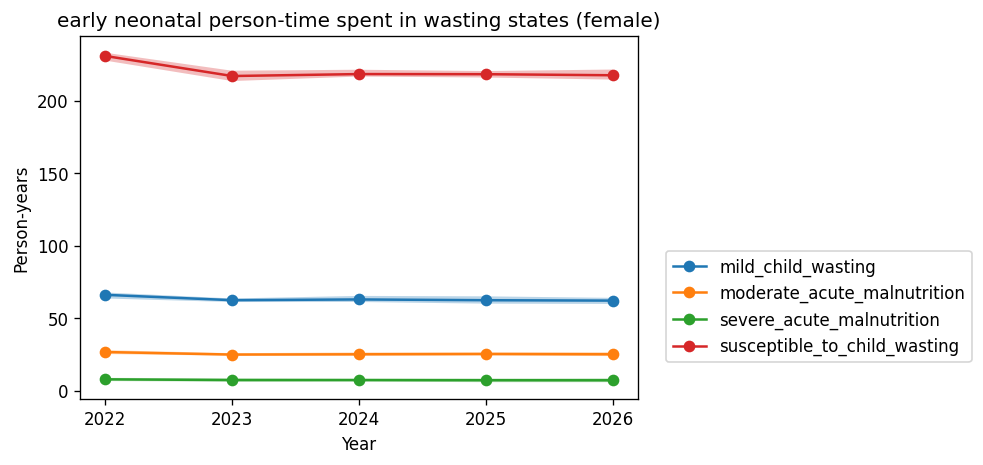

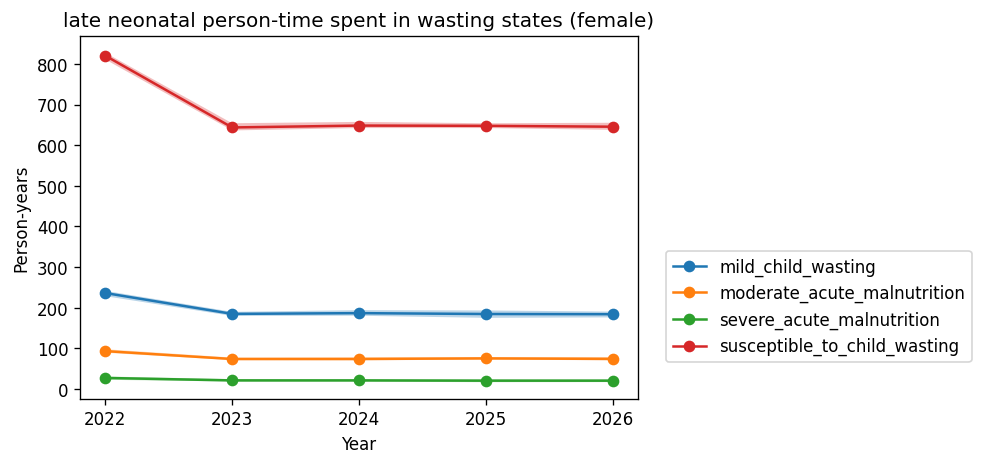

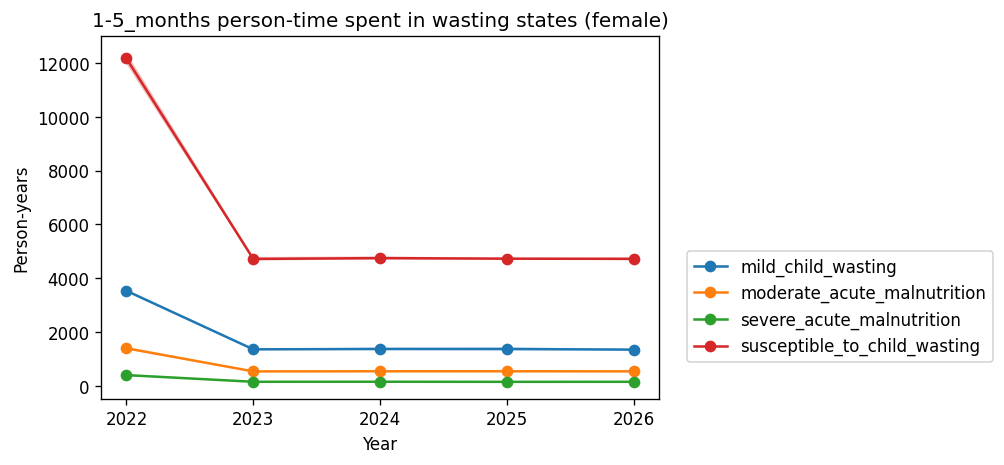

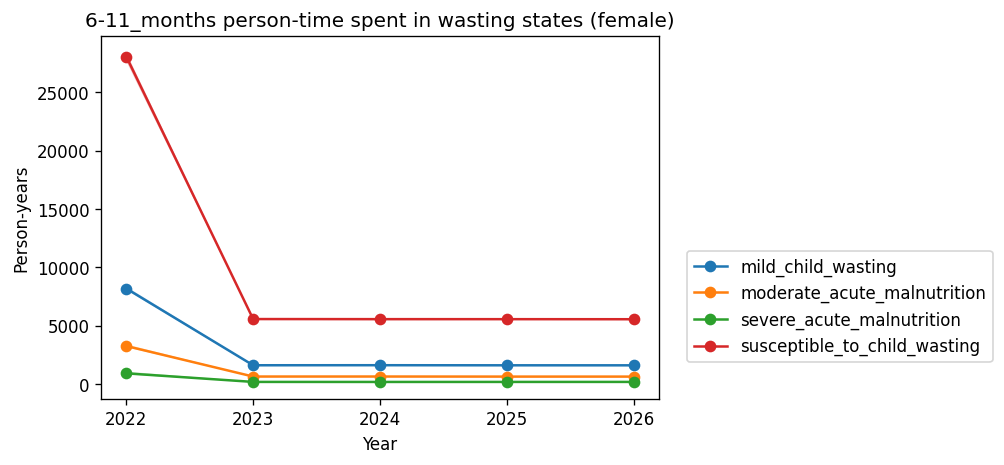

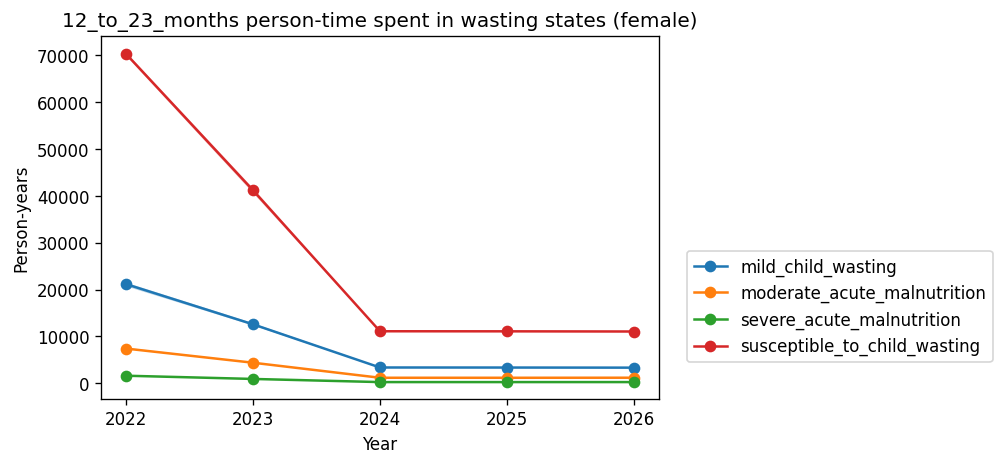

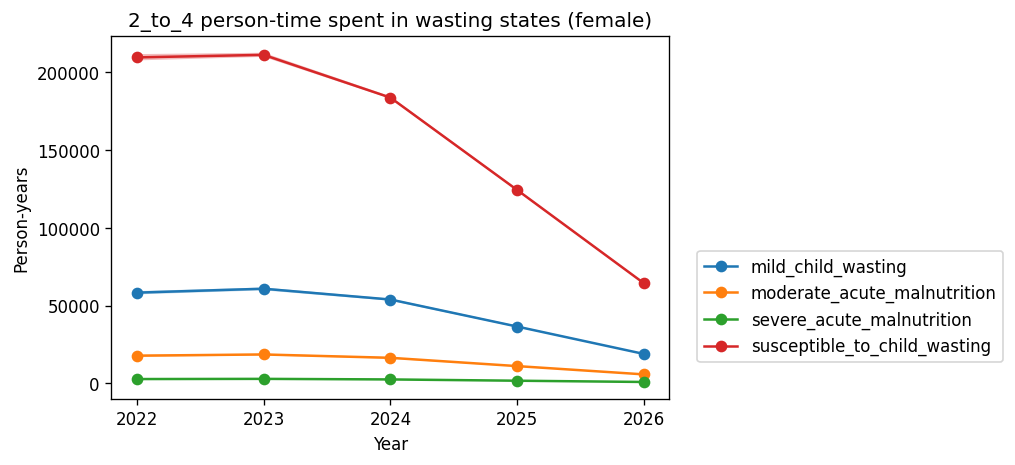

In [47]:
def plot_wasting_pt_over_time(df, sex, age_group):
    
    df.year = df.year.astype(int)
    state = df.cause.iloc[0]
    
    #{1: 'early_neonatal', 2: 'late_neonatal', 3: '1-5_months', 4: '6-11_months', 5: '12_to_23_months', 6:'2_to_4'}
    age_map = {1:'early neonatal',2:'late neonatal', 3: '1-5_months', 4: '6-11_months', 5: '12_to_23_months', 6:'2_to_4'}
    age = age_map[age_group]
    
    plt.figure(figsize=(6, 4), dpi=120)
    for cause in df.cause.unique():
        sub = df.loc[(df.sex==sex) & (df.age_group==age_group) & (df.cause==cause)]
        plt.plot(sub['year'], sub['mean'], marker='o', label=cause)
        plt.fill_between(sub['year'], sub['2.5%'], sub['97.5%'], alpha=.3)

    plt.legend(loc=(1.05, .1))
    plt.xlabel('Year')
    plt.ylabel('Person-years')
    plt.xticks(ticks = range(df.year.min(), df.year.max()+1))#, labels = ['early neonatal', 'late neonatal', 'post neonatal', '1 to 4'], rotation = 45) 
    plt.title(f'{age} person-time spent in wasting states ({sex})')

for age_group in pt_tmrel_wasting.age_group.unique():
    plot_wasting_pt_over_time(wasting_pt_df, sex = 'female', age_group = age_group)

In [48]:
def plot_sim_wasting(sim_data: pd.DataFrame, sex: str, sim_measure: str):
           
    ## add age label
    age_labels = {1:'early neonatal',2:'late neonatal', 3: '1-5_months', 4: '6-11_months', 5: '12_to_23_months', 6:'2_to_4'}
    sim_data['age_label'] = sim_data.age_group.map(age_labels)
    
    
    plt.figure(figsize=(6, 4), dpi=120)
    
    for year in sim_data.year.unique():
        sim_sub = sim_data[(sim_data.scenario == 'baseline') & 
                           (sim_data.year == year) & 
                           (sim_data.sex == sex)]
        plt.plot(sim_sub['age_group'], sim_sub['mean'], marker='o', label=year)
        plt.fill_between(sim_sub['age_group'], sim_sub['2.5%'], sim_sub['97.5%'], alpha=.3)
    
    plt.title(f'{sim_measure}, {sex}')
    plt.xlabel('Age')
    plt.xticks(ticks = [1, 2, 3, 4, 5, 6], labels = ['early neonatal', 'late neonatal', '1-5mo', '6-11mo', '1-2y', '2-4y'], rotation = 45)
          
    plt.legend(loc=(1.05, .1))
    plt.grid()
    

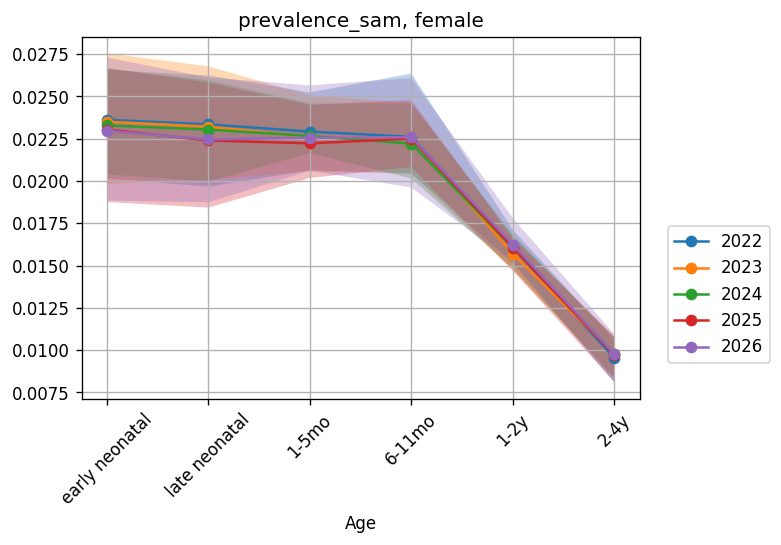

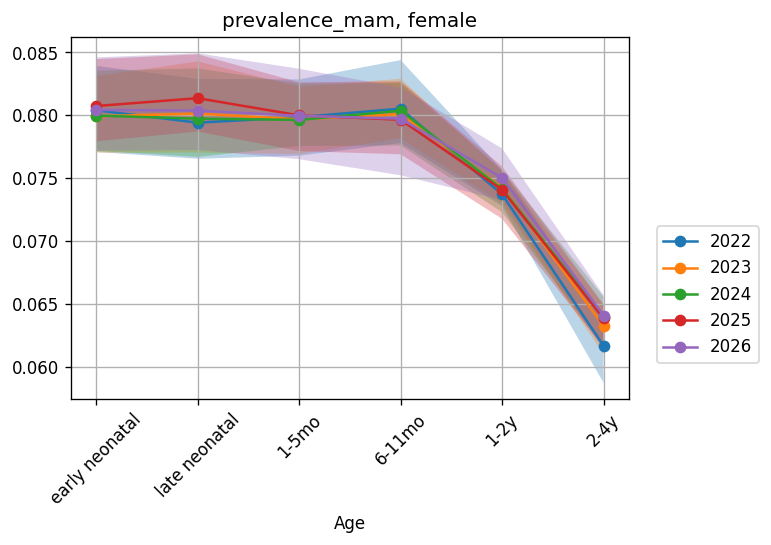

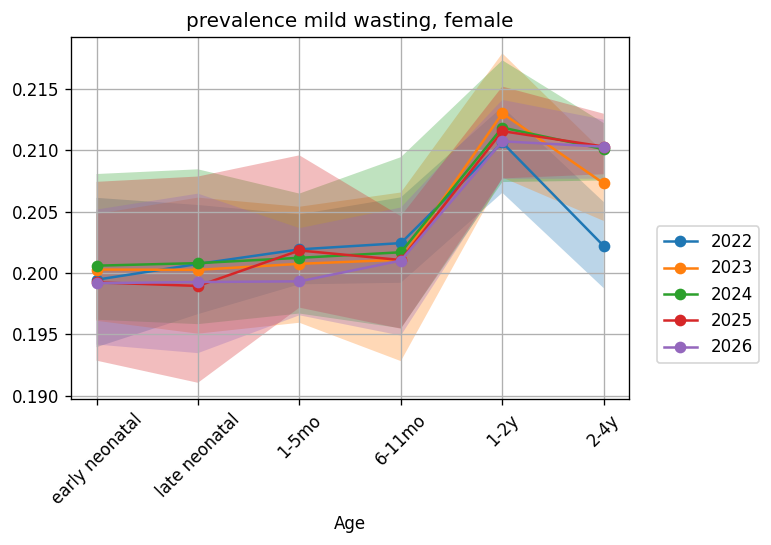

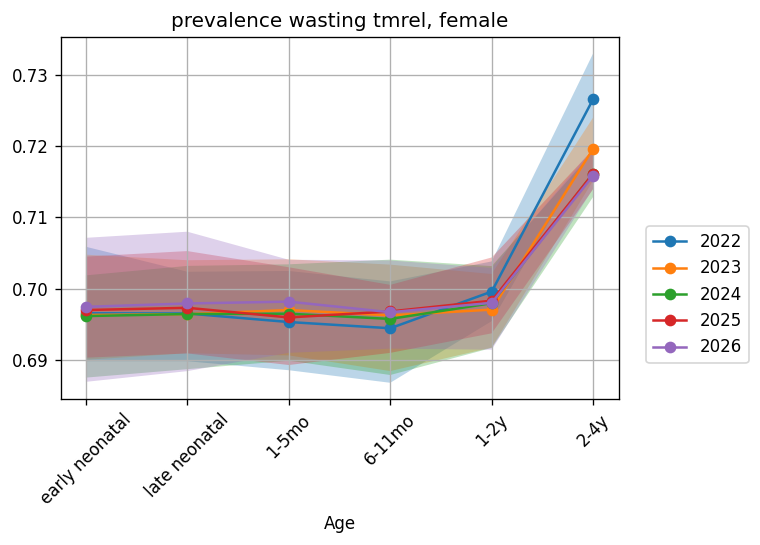

In [49]:
plot_sim_wasting(prevalence_sam, sex = 'female', sim_measure = 'prevalence_sam')
plot_sim_wasting(prevalence_mam, sex = 'female', sim_measure = 'prevalence_mam')
plot_sim_wasting(prevalence_mild, sex = 'female', sim_measure = 'prevalence mild wasting')
plot_sim_wasting(prevalence_wasting_tmrel, sex = 'female', sim_measure = 'prevalence wasting tmrel')

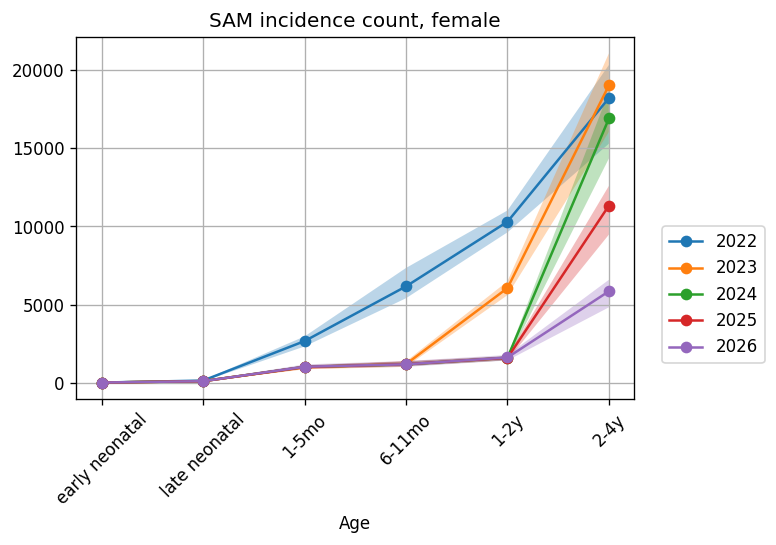

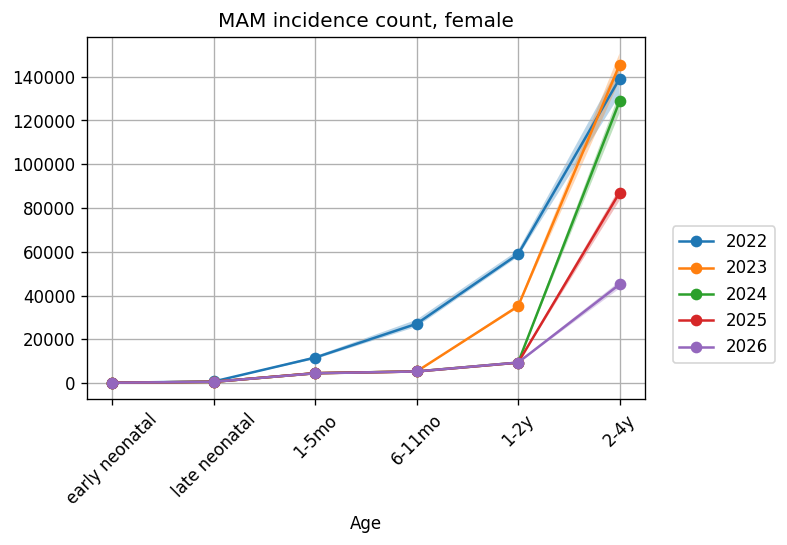

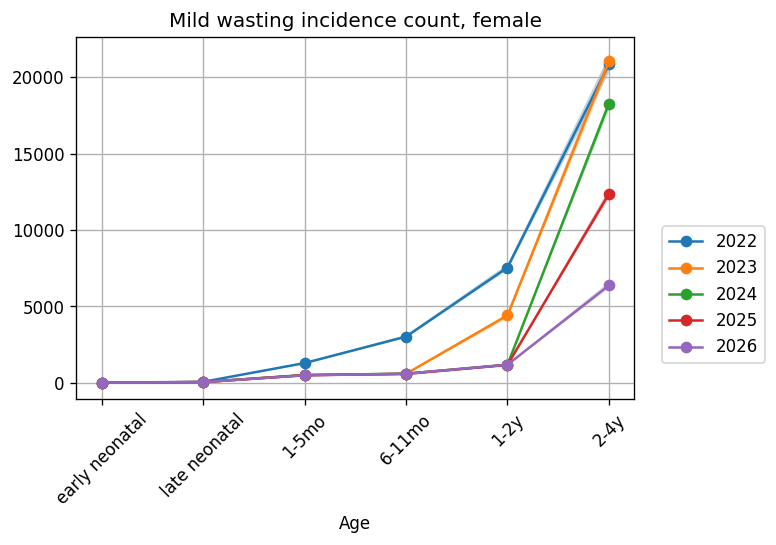

In [50]:
plot_sim_wasting(inc_count_sam, 'female', 'SAM incidence count')
plot_sim_wasting(inc_count_mam, 'female', 'MAM incidence count')
plot_sim_wasting(inc_count_mild, 'female', 'Mild wasting incidence count')

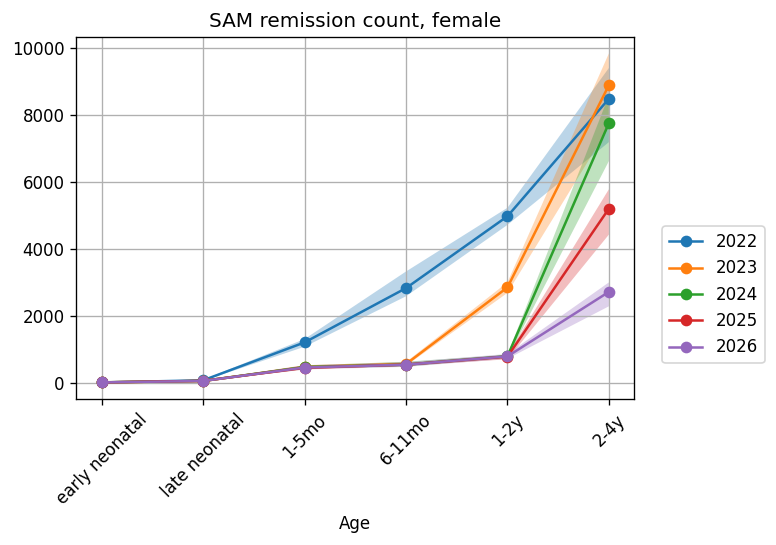

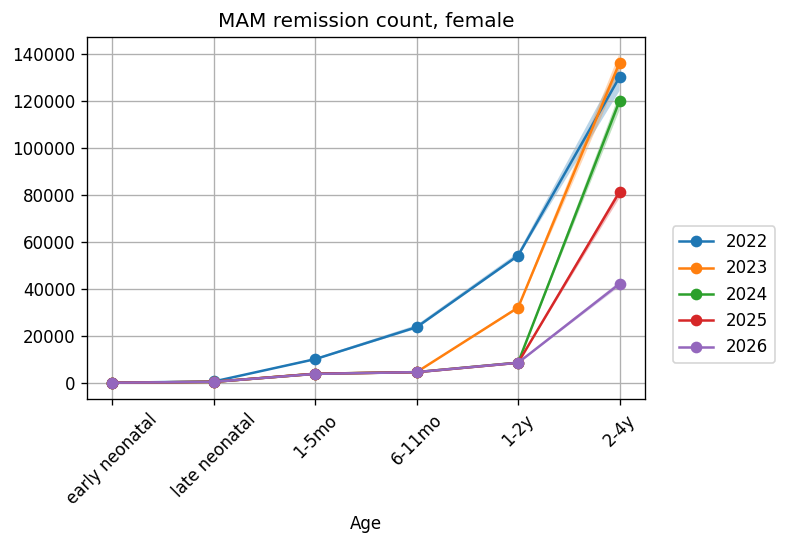

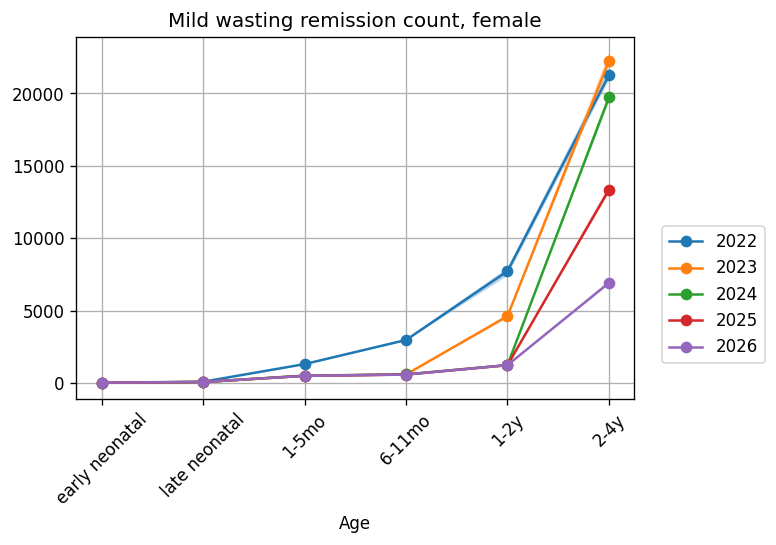

In [51]:
plot_sim_wasting(rem_count_sam, 'female', 'SAM remission count')
plot_sim_wasting(rem_count_mam, 'female', 'MAM remission count')
plot_sim_wasting(rem_count_mild, 'female', 'Mild wasting remission count')

In [52]:
art_wasting_prev.query("risk=='sam'")

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,age,age_group,risk,measure
0,female,0.000000,0.019178,2019,2020,0.024557,0.021287,0.028370,early_neonatal,1,sam,prevalence
4,female,0.019178,0.076712,2019,2020,0.024610,0.021256,0.028680,late_neonatal,2,sam,prevalence
8,female,0.076712,0.500000,2019,2020,0.024987,0.021183,0.028627,1-5_months,3,sam,prevalence
12,female,0.500000,1.000000,2019,2020,0.025921,0.022489,0.029991,6-11_months,4,sam,prevalence
...,...,...,...,...,...,...,...,...,...,...,...,...
32,male,0.076712,0.500000,2019,2020,0.040833,0.035179,0.046745,1-5_months,3,sam,prevalence
36,male,0.500000,1.000000,2019,2020,0.038799,0.033571,0.044388,6-11_months,4,sam,prevalence
40,male,1.000000,2.000000,2019,2020,0.028636,0.024285,0.032975,12_to_23_months,5,sam,prevalence
44,male,2.000000,5.000000,2019,2020,0.016175,0.013549,0.018823,2_to_4,6,sam,prevalence


In [53]:
prevalence_sam

,age_group,sex,year,scenario,measure,cause,mean,2.5%,97.5%,age_label
0,1,female,2022,baseline,state_person_time,severe_acute_malnutrition,0.023618,0.020158,0.026560,early neonatal
1,1,female,2023,baseline,state_person_time,severe_acute_malnutrition,0.023503,0.019828,0.027544,early neonatal
2,1,female,2024,baseline,state_person_time,severe_acute_malnutrition,0.023284,0.020392,0.026639,early neonatal
3,1,female,2025,baseline,state_person_time,severe_acute_malnutrition,0.023042,0.018756,0.026680,early neonatal
...,...,...,...,...,...,...,...,...,...,...
56,6,male,2023,baseline,state_person_time,severe_acute_malnutrition,0.015546,0.013884,0.017052,2_to_4
57,6,male,2024,baseline,state_person_time,severe_acute_malnutrition,0.015430,0.013608,0.016981,2_to_4
58,6,male,2025,baseline,state_person_time,severe_acute_malnutrition,0.015422,0.013758,0.016895,2_to_4
59,6,male,2026,baseline,state_person_time,severe_acute_malnutrition,0.015327,0.013869,0.016528,2_to_4


In [54]:
prevalence_mam

,age_group,sex,year,scenario,measure,cause,mean,2.5%,97.5%,age_label
0,1,female,2022,baseline,state_person_time,moderate_acute_malnutrition,0.080404,0.077089,0.083934,early neonatal
1,1,female,2023,baseline,state_person_time,moderate_acute_malnutrition,0.079927,0.077030,0.083108,early neonatal
2,1,female,2024,baseline,state_person_time,moderate_acute_malnutrition,0.079984,0.077176,0.083548,early neonatal
3,1,female,2025,baseline,state_person_time,moderate_acute_malnutrition,0.080742,0.077935,0.084476,early neonatal
...,...,...,...,...,...,...,...,...,...,...
56,6,male,2023,baseline,state_person_time,moderate_acute_malnutrition,0.075652,0.073249,0.077850,2_to_4
57,6,male,2024,baseline,state_person_time,moderate_acute_malnutrition,0.076739,0.074650,0.078754,2_to_4
58,6,male,2025,baseline,state_person_time,moderate_acute_malnutrition,0.076608,0.074344,0.078392,2_to_4
59,6,male,2026,baseline,state_person_time,moderate_acute_malnutrition,0.076437,0.073866,0.078322,2_to_4


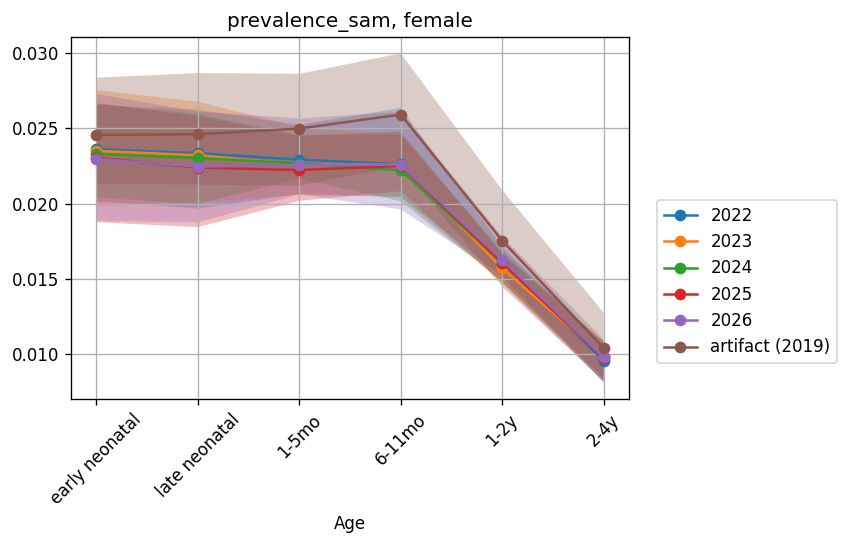

In [65]:
def plot_sim_vs_art_wasting(sim_data: pd.DataFrame, art_data: pd.DataFrame, sex: str, sim_measure: str):
           
    ## add age label
    age_labels = {1:'early neonatal',2:'late neonatal', 3: '1-5_months', 4: '6-11_months', 5: '12_to_23_months', 6:'2_to_4'}
    sim_data['age_label'] = sim_data.age_group.map(age_labels)
    
    
    plt.figure(figsize=(6, 4), dpi=120)
    
    for year in sim_data.year.unique():
        sim_sub = sim_data[(sim_data.scenario == 'baseline') & 
                           (sim_data.year == year) & 
                           (sim_data.sex == sex)]
        plt.plot(sim_sub['age_group'], sim_sub['mean'], marker='o', label=year)
        plt.fill_between(sim_sub['age_group'], sim_sub['2.5%'], sim_sub['97.5%'], alpha=.3)
        
    art_sub = art_data.query("sex==@sex")
    plt.plot(art_sub['age_group'], art_sub['mean'], marker='o', label="artifact (2019)")
    plt.fill_between(art_sub['age_group'], art_sub['2.5%'], art_sub['97.5%'], alpha=.3)
    
    plt.title(f'{sim_measure}, {sex}')
    plt.xlabel('Age')
    plt.xticks(ticks = [1, 2, 3, 4, 5, 6], labels = ['early neonatal', 'late neonatal', '1-5mo', '6-11mo', '1-2y', '2-4y'], rotation = 45)
          
    plt.legend(loc=(1.05, .1))
    plt.grid()

plot_sim_vs_art_wasting(prevalence_sam, art_wasting_prev.query("risk=='sam'"), sex = 'female', sim_measure = 'prevalence_sam')

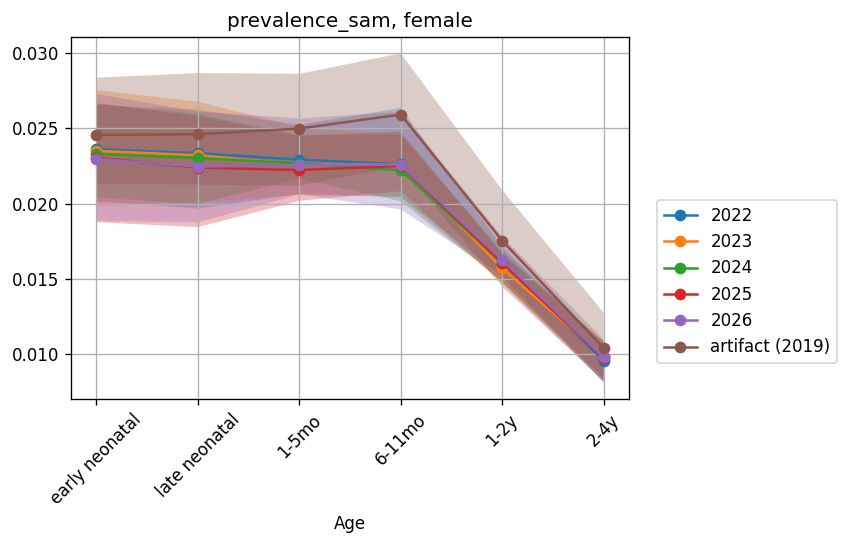

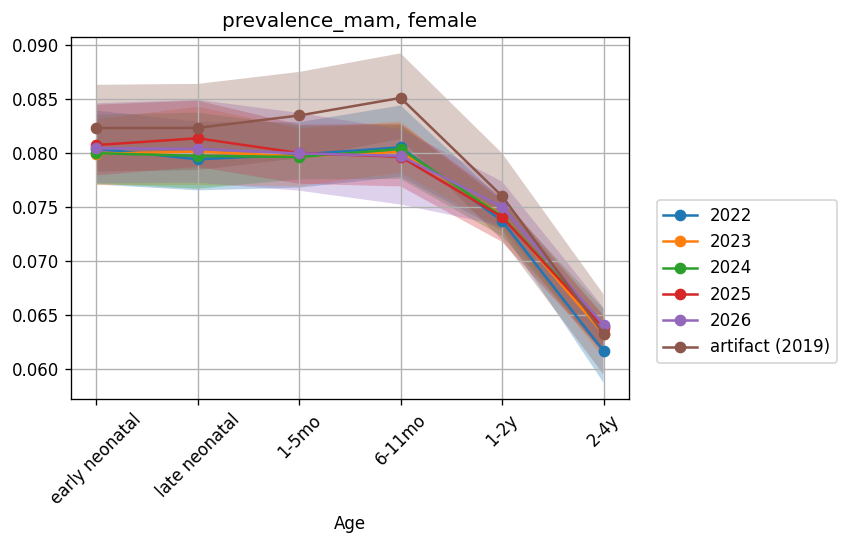

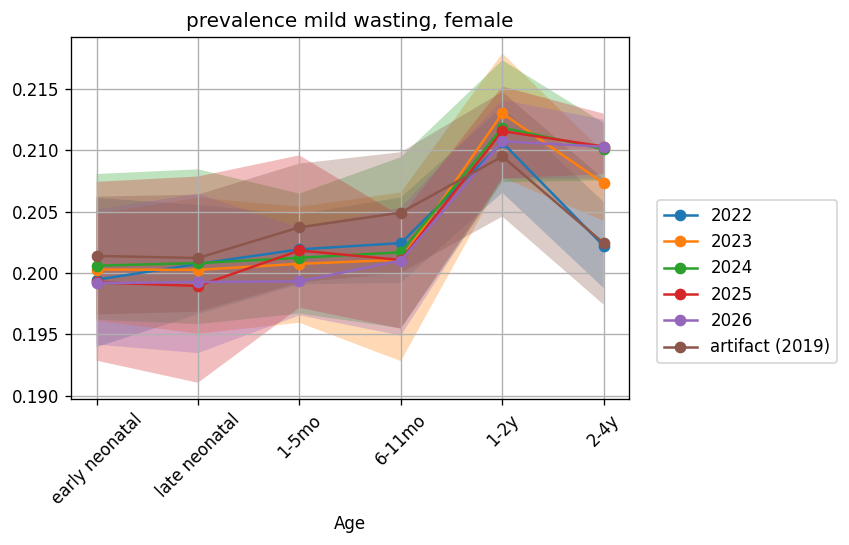

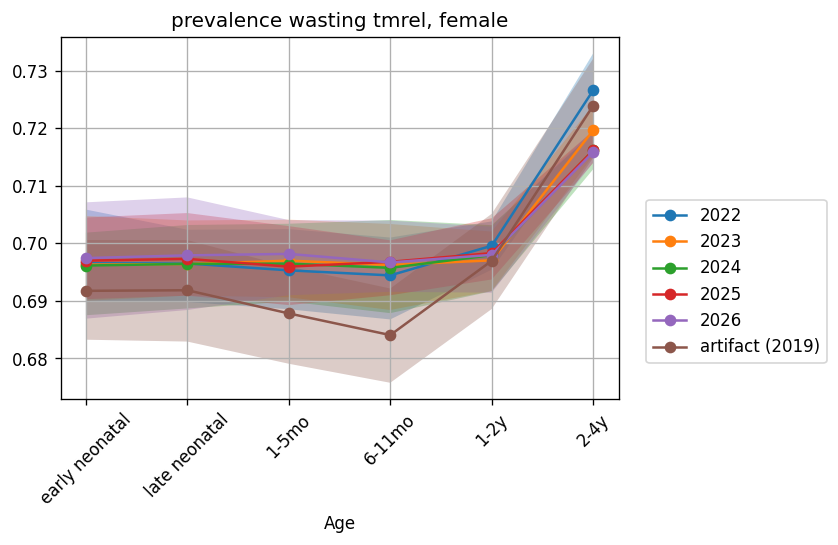

In [56]:
# plot_sim_vs_art_wasting(prevalence_sam, wasting_prev.query("risk=='sam'"), sex = 'female', sim_measure = 'prevalence_sam')
plot_sim_vs_art_wasting(prevalence_sam, sam_prev, sex = 'female', sim_measure = 'prevalence_sam')
plot_sim_vs_art_wasting(prevalence_mam, mam_prev, sex = 'female', sim_measure = 'prevalence_mam')
plot_sim_vs_art_wasting(prevalence_mild, mild_prev, sex = 'female', sim_measure = 'prevalence mild wasting')
plot_sim_vs_art_wasting(prevalence_wasting_tmrel, sus_wasting_prev, sex = 'female', sim_measure = 'prevalence wasting tmrel')

In [57]:
output_dir

'/share/scratch/users/ndbs/vivarium_results/ciff_malnutrition/verification_and_validation/v2.3_wasting_birth_prevalence/'

In [59]:
ls /share/scratch/users/ndbs/vivarium_results/ciff_malnutrition/verification_and_validation/v2.3_wasting_birth_prevalence/

In [60]:
art_wasting_prev['risk'].unique()

array(['sam', 'mam', 'mild_wasting', 'tmrel_wasting'], dtype=object)

In [61]:
sim_wasting_prev = (
    pd.concat([prevalence_sam, prevalence_mam, prevalence_mild, prevalence_wasting_tmrel], ignore_index=True)
    .assign(
        risk=lambda df: df['cause'].map(
            {'severe_acute_malnutrition': 'sam',
             'moderate_acute_malnutrition': 'mam',
             'mild_child_wasting': 'mild_wasting',
             'susceptible_to_child_wasting': 'tmrel_wasting'
            })
           )
)
sim_wasting_prev

,age_group,sex,year,scenario,measure,cause,mean,2.5%,97.5%,age_label,risk
0,1,female,2022,baseline,state_person_time,severe_acute_malnutrition,0.023618,0.020158,0.026560,early neonatal,sam
1,1,female,2023,baseline,state_person_time,severe_acute_malnutrition,0.023503,0.019828,0.027544,early neonatal,sam
2,1,female,2024,baseline,state_person_time,severe_acute_malnutrition,0.023284,0.020392,0.026639,early neonatal,sam
3,1,female,2025,baseline,state_person_time,severe_acute_malnutrition,0.023042,0.018756,0.026680,early neonatal,sam
...,...,...,...,...,...,...,...,...,...,...,...
236,6,male,2023,baseline,state_person_time,susceptible_to_child_wasting,0.687357,0.681881,0.691019,2_to_4,tmrel_wasting
237,6,male,2024,baseline,state_person_time,susceptible_to_child_wasting,0.682436,0.678442,0.685885,2_to_4,tmrel_wasting
238,6,male,2025,baseline,state_person_time,susceptible_to_child_wasting,0.682894,0.678865,0.685988,2_to_4,tmrel_wasting
239,6,male,2026,baseline,state_person_time,susceptible_to_child_wasting,0.684064,0.681538,0.687436,2_to_4,tmrel_wasting


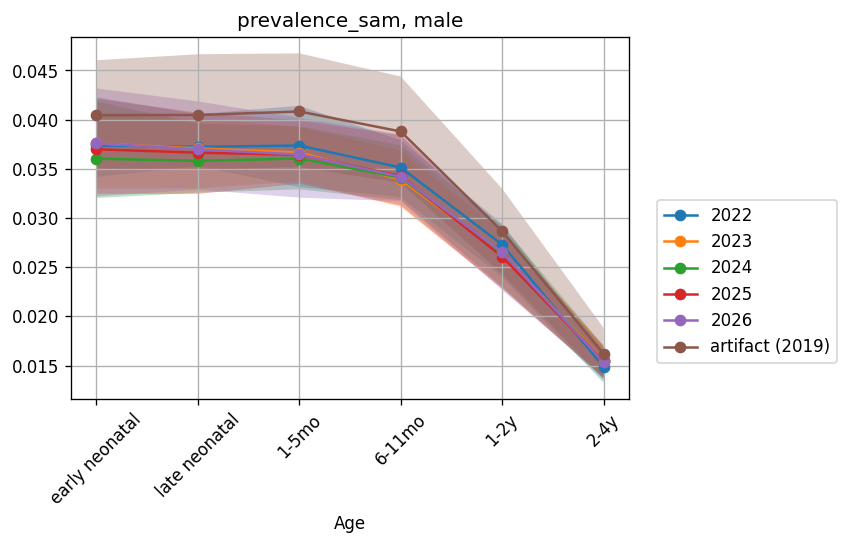

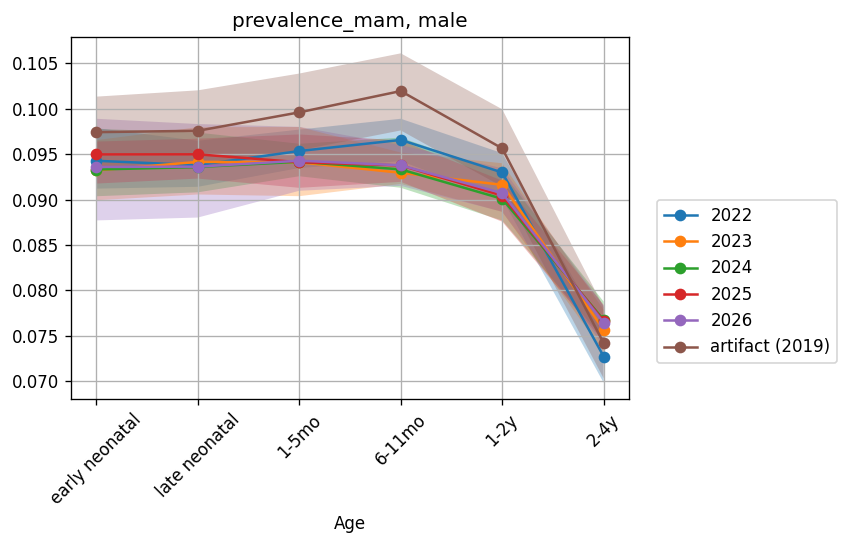

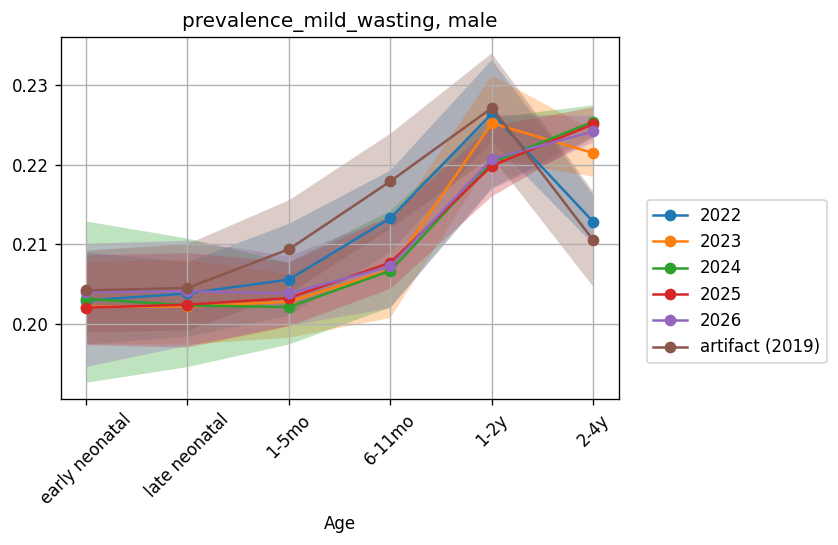

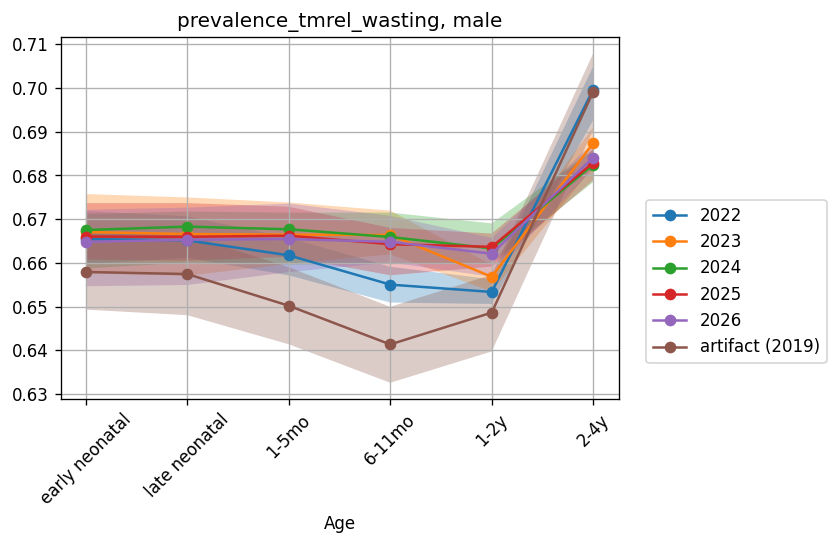

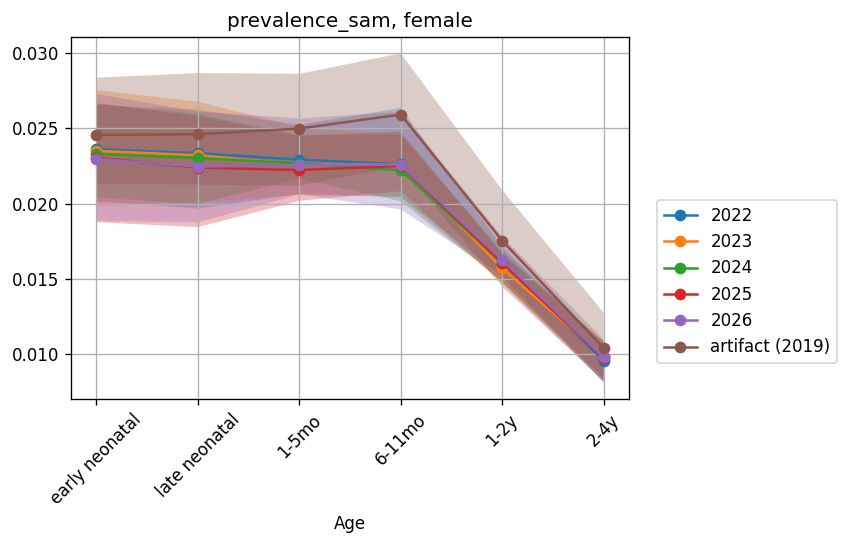

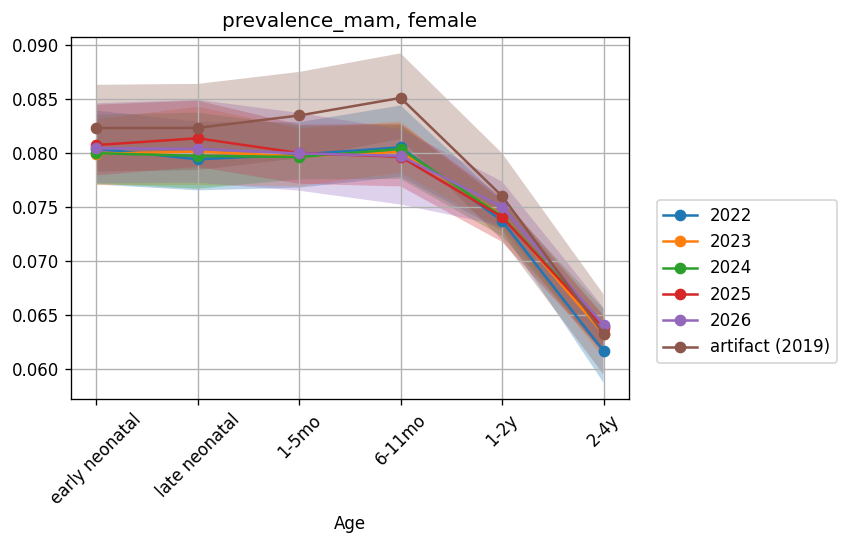

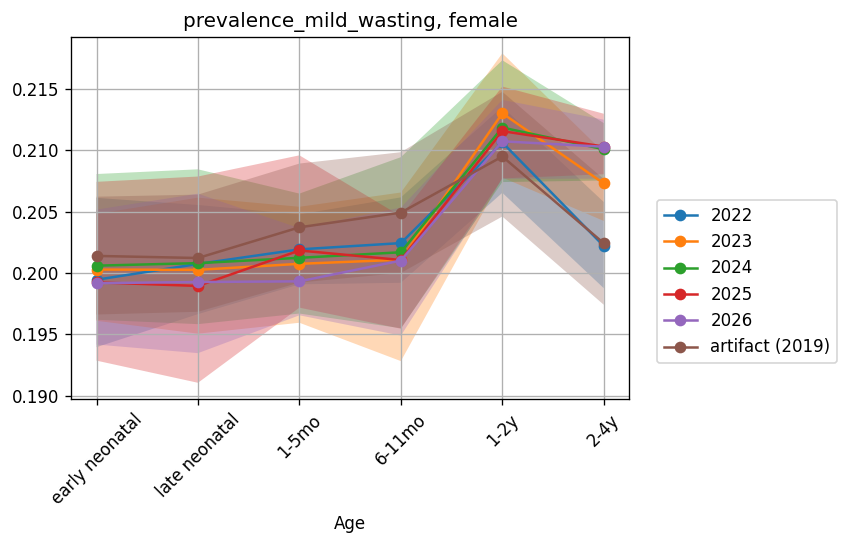

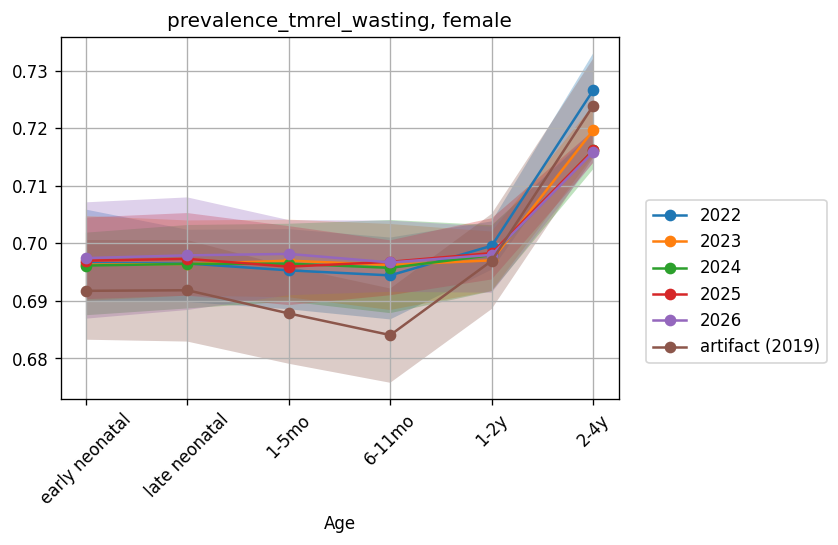

In [62]:
with PdfPages(output_dir + 'wasting_prevalence.pdf') as pdf:
    for sex in ('male', 'female'):
        for risk_cat in ('sam', 'mam', 'mild_wasting', 'tmrel_wasting'):
            plot_sim_vs_art_wasting(
                sim_wasting_prev.query('risk==@risk_cat'),
                art_wasting_prev.query('risk==@risk_cat'),
                sex = sex,
                sim_measure = f'prevalence_{risk_cat}'
            )
            pdf.savefig(bbox_inches='tight')

In [63]:
ls /share/scratch/users/ndbs/vivarium_results/ciff_malnutrition/verification_and_validation/v2.3_wasting_birth_prevalence/

wasting_prevalence.pdf
